In [3]:
#!/usr/bin/env python
import pickle

from coffea import processor
from coffea.nanoevents import NanoAODSchema
NanoAODSchema.warn_missing_crossrefs = True

from HNLAnalysis import HNLAnalysis
from CountEvents import CountEvents

from samples import signal_samples, Data_samples, MCbackground_samples
from xsecs import xsecs
from helpers import files_from_path
from plot_helpers import compute_lumi

import re
import csv
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
%matplotlib inline
import warnings
from coffea import hist

In [4]:
#load results

#option used to produce results
tag = 'test_channelttm_regionD'
figure_path = '/Users/debryas/Desktop/PhD_work/HNL_tau_analysis/hnl-coffea-analysis/figures/'+tag+'/'

with open(f'results/result_{tag}.pkl', 'rb') as f:
    result = pickle.load(f)
with open (f'results/counter_{tag}.pkl', 'rb') as f:
    event_counter = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'results/counter_test_channelttm_regionD.pkl'

In [4]:
# store all the samples 
Data_samples_merged = {}
for s in Data_samples:
    Data_samples_merged[s[0:-1]] = Data_samples[s]

samples = {**signal_samples, **Data_samples_merged, **MCbackground_samples}

In [5]:
#print cutflow of events
variable = 'n_ev'

print('Cutflow of the events by channel and sample')

table = []
headers = []

headers.append("data\nchannel")
table.append([])
table[0].append('all')

i=1
for selection in HNLAnalysis.get_selections():
    table.append([])
    table[i].append(selection)
    i= i+1

table.append([])
table[i].append('total')

for s in samples.keys():
    headers.append(str(s)+f'\n{"tte":<5} | {"ttm":<5} | {"tee":<5} | {"tmm":<5} | {"tem_SS":<5} | {"tem_OS":<5} | {"ttt":<5}')
    table[0].append(round(result[variable+'_all'][s],4))
    j=1
    combined_channel_end = 0
    for selection in HNLAnalysis.get_selections():
        channel_table_str = ''
        for channel in HNLAnalysis.get_channels():
            channel_table_str = channel_table_str + f' {round(result[f"{variable}_{selection}_{channel}"][s],1):<5} |'
            if selection == HNLAnalysis.get_selections()[-1]:
                combined_channel_end = combined_channel_end + round(result[f'{variable}_{selection}_{channel}'][s],4)
    
        table[j].append(channel_table_str[0:-2])
        j= j+1
    table[i].append(combined_channel_end)
    
print(tabulate(table, headers, tablefmt="fancy_grid"))

Cutflow of the events by channel and sample
╒══════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╤════════════════════════════════════════

In [6]:
# load luminosity of data files

luminosity = {}
for element in Data_samples:
    luminosity[element] = compute_lumi(element)
    
lumi_EGamma_2018 = 0
lumi_SingleMuon_2018 = 0
lumi_Tau_2018 = 0
for element in Data_samples:
    if element[:-1] == 'Data_EGamma_2018':
        lumi_EGamma_2018 += luminosity[element]
    if element[:-1] == 'Data_SingleMuon_2018':
        lumi_SingleMuon_2018 += luminosity[element]
    if element[:-1] == 'Data_Tau_2018':
        lumi_Tau_2018 += luminosity[element]

In [7]:
#print cutflow of signal yield

print('Cutflow of the signal yield by samples (sum over all channels)')

table = []
headers = []

headers.append(" ")
table.append([])
table[0].append('lumi X xsec')

i=1
for selection in HNLAnalysis.get_selections():
    table.append([])
    table[i].append(selection)
    i= i+1

for s in samples.keys():
    lumi = 59832.47 #2018 luminosity
    if 'EGamma' in s:
        lumi = lumi_EGamma_2018 
    if 'SingleMuon' in s:
        lumi = lumi_SingleMuon_2018 
    if 'Tau' in s:
        lumi = lumi_Tau_2018 
    if 'Data' in s:
        headers.append(str(s))
        table[0].append(round(lumi,4))
    else:
        headers.append(str(s))
        table[0].append(round(lumi*xsecs[s],4))
    
    j=1
    for selection in HNLAnalysis.get_selections():
        combined_channel = 0
        for channel in HNLAnalysis.get_channels():
            if 'Data' in s:
                combined_channel = combined_channel + (result[f"n_ev_{selection}_{channel}"][s])
            else:
                if event_counter["sumw"][s] == 0:
                    print('check channel ' + channel + ' for ' + s)
                    combined_channel = 0
                else:
                    combined_channel = combined_channel + (result[f"sumw_{selection}_{channel}"][s]*lumi*xsecs[s]/event_counter["sumw"][s])
        table[j].append(round(combined_channel,3))
        j= j+1
    
print(tabulate(table, headers, tablefmt="fancy_grid"))

Cutflow of the signal yield by samples (sum over all channels)
╒══════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╤══════════════════╤═══════════════╤═══════════════════╤════════════╤═════════════════════════╤══════════════════════════════════╤═════════════════════════════════╤════════════════════════════════╤═══════════════════════════╤═══════════════════════════════════════════╤═══════════════════════════════════════╤════════════════════════════════════╤════════════════════════════════╤════════════════╤══════════════════╤══════════════════════╤══════════════════╤═════════╤═════════╤══════════════════════╤═════════╤════════════════╤═══════════════╤════════════════╤════════════╤═══════════╤══════════╤══════════╤═════════╕
│              │   HNL_tau_M-100 │   HNL_tau_M-200 │   HNL_tau_M-300 │   HNL_tau_M-400 │   HNL_tau_M-500 │   HNL_tau_M-600 │   HNL_tau_M-700 │

In [8]:
# signal_yield will store the signal yield after each cut for all samples
signal_yield = {}
for sample in samples.keys():
    # find the correct luminosity
    lumi = 59832.47 #2018 luminosity
    if 'EGamma' in sample:
        lumi = lumi_EGamma_2018 
    if 'SingleMuon' in sample:
        lumi = lumi_SingleMuon_2018 
    if 'Tau' in sample:
        lumi = lumi_Tau_2018 

    cutflow = []
    # First the luminosity x Xsec (Xsec = 1 for data)
    cutflow.append(round(lumi*xsecs[sample],4))

    for selection in HNLAnalysis.get_selections():
        # combined signal yield for all channel
        combined_channel = 0
        for channel in HNLAnalysis.get_channels():
            if 'Data' in sample:
                combined_channel = combined_channel + (result[f"n_ev_{selection}_{channel}"][sample])
            else:
                if event_counter["sumw"][sample] == 0:
                    combined_channel = 0
                else:
                    combined_channel = combined_channel + (result[f"sumw_{selection}_{channel}"][sample]*lumi*xsecs[sample]/event_counter["sumw"][sample])
        cutflow.append(round(combined_channel,4))

    signal_yield[sample] = cutflow


#normalisation by previous signal yield
normalised_signal_yield = {}
for sample in signal_yield.keys():
    if 'HNL' in sample:
        normalised_signal_yield[sample] = np.array(signal_yield[sample])
        denominateur = signal_yield[sample][0]
        for i in range(len(signal_yield[sample])):
            normalised_signal_yield[sample][i] = normalised_signal_yield[sample][i]/denominateur
            denominateur = signal_yield[sample][i]

# cut to show
cut = []
cut.append('lumi*xsecs')
for selection in HNLAnalysis.get_selections():
    cut.append(selection)

/Users/debryas/opt/anaconda3/envs/HNL/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


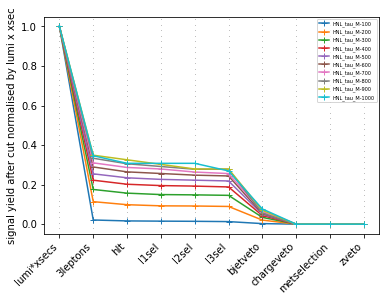

In [9]:
#plot signal_yield_HNL normalised by lumi x xsec
fig, ax = plt.subplots(1,1)
for sample in signal_yield.keys():
    if 'HNL' in sample:
        ax.errorbar(range(len(cut)),np.array(signal_yield[sample])/np.array(signal_yield[sample][0]) , fmt='+-', capsize=5, label=sample)
ax.set_ylabel('signal yield after cut normalised by lumi x xsec')
ax.set_xticks(range(len(cut)))
ax.set_xticklabels(cut, rotation=45, ha='right')
ax.grid(axis='x', color='black', linestyle=(0, (1, 10)), linewidth=0.5)
ax.legend(prop={'size': 5})
plt.savefig(figure_path + 'signal_yield_HNL.pdf', bbox_inches='tight')

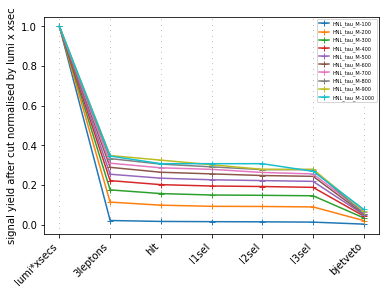

In [30]:
#plot signal_yield_HNL normalised by lumi x xsec
fig, ax = plt.subplots(1,1)
for sample in signal_yield.keys():
    if 'HNL' in sample:
        ax.errorbar(range(len(cut))[0:7],np.array(signal_yield[sample])[0:7]/np.array(signal_yield[sample][0]) , fmt='+-', capsize=5, label=sample)
ax.set_ylabel('signal yield after cut normalised by lumi x xsec')
ax.set_xticks(range(len(cut))[0:7])
ax.set_xticklabels(cut[0:7], rotation=45, ha='right')
ax.grid(axis='x', color='black', linestyle=(0, (1, 10)), linewidth=0.5)
ax.legend(prop={'size': 5})
plt.savefig(figure_path + 'signal_yield_HNL.pdf', bbox_inches='tight')

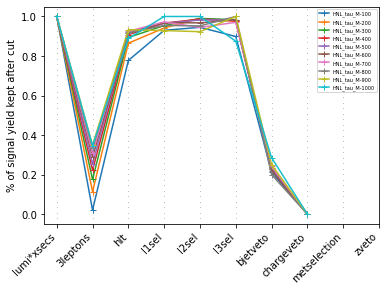

In [15]:
# plotting signal yield kept after each cut (in %)
fig, ax = plt.subplots(1,1)
for sample in normalised_signal_yield.keys():
    if 'HNL' in sample:
        ax.errorbar(range(len(cut)),normalised_signal_yield[sample] , fmt='+-', capsize=5, label=sample)
ax.set_ylabel('% of signal yield kept after cut')
ax.set_xticks(range(len(cut)))
ax.set_xticklabels(cut, rotation=45, ha='right')
ax.grid(axis='x', color='black', linestyle=(0, (1, 10)), linewidth=0.5)
ax.legend(prop={'size': 5})
plt.savefig(figure_path + 'normalised_signal_yield_hnl.pdf', bbox_inches='tight')

In [11]:
reducible_background={'DYJets_To_LL_M-10to50',
                      'DYJets_To_LL_M-50-amcatnloFXFX',
                      'EWK_WMinus2Jets_W_To_LNu_M-50', 
                      'EWK_WPlus2Jets_W_To_LNu_M-50', 
                      'EWK_Z2Jets_Z_To_LL_M-50',
                      'TT_To_2L2Nu', 
                      'TT_To_SemiLeptonic', 
                      'TT_To_Hadronic', 
                      'ST_tW_antitop_5f_inclusiveDecays',
                      'ST_tW_top_5f_inclusiveDecays', 
                      'ST_t-channel_antitop_4f_InclusiveDecays',
                      'ST_t-channel_top_4f_InclusiveDecays',
                      'WJets_To_LNu', 
                      'ZZ', 
                      'WW'}

rare_background={'TTWJets_To_LNu',
                 'TTZ_To_LLNuNu_M-10', 
                 'TTWW', 
                 'TTZZ', 
                 'TTWZ',
                 'WWW_4F', 
                 'ZZZ' ,
                 'WZZ', 
                 'WWZ_4F'}        

WZ_background={'WZ'}

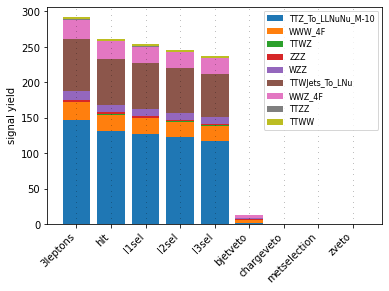

In [12]:
# all rare background
x = range(len(cut)-1)
fig, ax = plt.subplots(1,1)
cumu = np.zeros(len(cut)-1)
for bck in rare_background:
        ax.bar(x, np.array(signal_yield[bck][1:]), label=bck, bottom = cumu)
        cumu = cumu + np.array(signal_yield[bck][1:])
ax.set_ylabel('signal yield')
ax.set_xticks(x)
ax.set_xticklabels(cut[1:], rotation=45, ha='right')
ax.grid(axis='x', color='black', linestyle=(0, (1, 10)), linewidth=0.5)
ax.legend(prop={'size': 8})
plt.savefig(figure_path + 'rare_MCbackground_yield_cutflow.pdf', bbox_inches='tight')

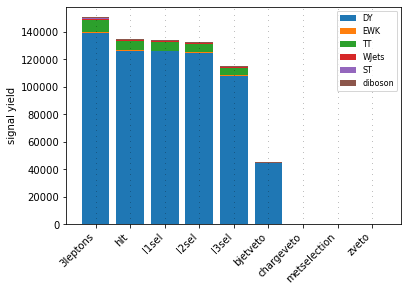

In [13]:
# all reducible background

#merged in sublist
reducible_bck_list={}
reducible_bck_list['DY'] = ['DYJets_To_LL_M-10to50', 'DYJets_To_LL_M-50-amcatnloFXFX']
reducible_bck_list['EWK'] = ['EWK_WMinus2Jets_W_To_LNu_M-50', 'EWK_WPlus2Jets_W_To_LNu_M-50', 'EWK_Z2Jets_Z_To_LL_M-50']
reducible_bck_list['TT'] = ['TT_To_2L2Nu', 'TT_To_SemiLeptonic', 'TT_To_Hadronic']
reducible_bck_list['WJets'] = ['WJets_To_LNu']
reducible_bck_list['ST'] = ['ST_tW_antitop_5f_inclusiveDecays','ST_tW_top_5f_inclusiveDecays', 'ST_t-channel_antitop_4f_InclusiveDecays','ST_t-channel_top_4f_InclusiveDecays']
reducible_bck_list['diboson'] = ['ZZ', 'WW']

reducible_background_signal_yield = {}
for category in reducible_bck_list.keys():
    sum = np.zeros(len(cut))
    for bck in reducible_bck_list[category]:
        sum = sum + np.array(signal_yield[bck])
    reducible_background_signal_yield[category] = sum

x = range(len(cut)-1)
fig, ax = plt.subplots(1,1)
cumu = np.zeros(len(cut)-1)
for category in reducible_bck_list.keys():
        ax.bar(x, np.array(reducible_background_signal_yield[category][1:]), label=category, bottom = cumu)
        cumu = cumu + np.array(reducible_background_signal_yield[category][1:])
ax.set_ylabel('signal yield')
ax.set_xticks(x)
ax.set_xticklabels(cut[1:], rotation=45, ha='right')
ax.grid(axis='x', color='black', linestyle=(0, (1, 10)), linewidth=0.5)
ax.legend(prop={'size': 8})
plt.savefig(figure_path + 'reducible_MCbackground_yield_cutflow.pdf', bbox_inches='tight')

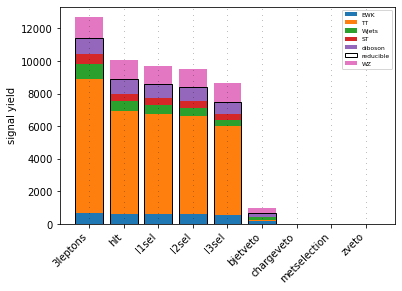

In [14]:
# all reducible background except DYJets_To_LL_M-50 and WZ

x = range(len(cut)-1)
fig, ax = plt.subplots(1,1)
cumu = np.zeros(len(cut)-1)
for category in reducible_bck_list.keys():
    if category != 'DY':
        ax.bar(x, np.array(reducible_background_signal_yield[category][1:]), label=category, bottom = cumu)
        cumu = cumu + np.array(reducible_background_signal_yield[category][1:])
ax.bar(x, cumu, label='reducible',fill = False, edgecolor = 'black')
ax.bar(x, np.array(signal_yield['WZ'][1:]), label='WZ', bottom = cumu)
ax.set_ylabel('signal yield')
ax.set_xticks(x)
ax.set_xticklabels(cut[1:], rotation=45, ha='right')
ax.grid(axis='x', color='black', linestyle=(0, (1, 10)), linewidth=0.5)
ax.legend(prop={'size': 6})
plt.savefig(figure_path + 'reducible_MCbackground_yield_cutflow_WZ_noDY.pdf', bbox_inches='tight')